# Discrete state space with features

In [1]:
import sys
import torchvision
import numpy as np
from envs.navigation.DiscreteStateSpace import DiscreteStateSpace

sys.path.append("./NavigationGridViews/")
from NavigationGridViews.navgridviews.Raster import Raster as NavGridView

from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

In [2]:
fmnist = torchvision.datasets.FashionMNIST(root="./", download=True)
X, y = fmnist.data, fmnist.targets

def sample_image(X, y, y_q):    
    x_q = X[y == y_q].numpy()
    return x_q[np.random.randint(0, len(x_q))]

In [3]:
n_rows, n_cols = 5, 5
select_classes = [0, 1, 2, 3, 4]
class_prob = [0.2] * 5

In [4]:
dss = DiscreteStateSpace(n_rows, n_cols)
dss.attach_classes(select_classes, class_prob)
dss.attach_features(kind="attrib_to_feature_map", attrib_to_feature_map={cls: sample_image(X, y, cls) \
                                                                         for cls in select_classes})
grid_data = dss.features_lst
grid_targets = dss.class_ids

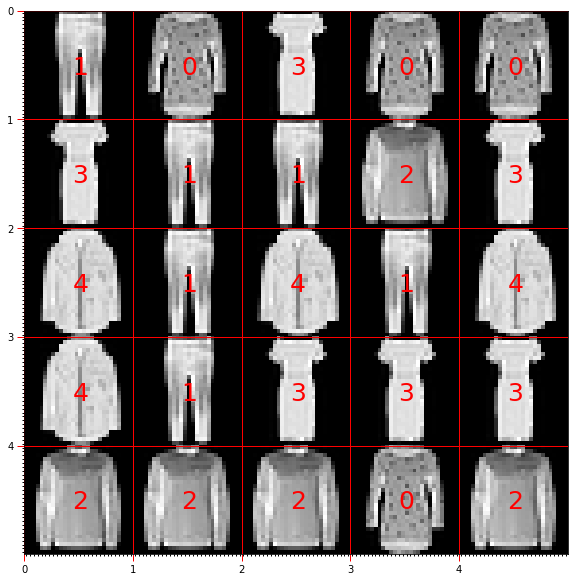

In [5]:
fig = plt.figure(figsize=(10,10))
NavGridView(grid_data[:,:,:,np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().show_cell_text(
    grid_targets, fmt=".1f", color_cb=lambda x: "red", fontsize=25)